# 3 Statsmodels 入門

## 3.1 Autoregressive AR-X(p) model (Autoreg model)

自己回帰モデルは次のようなダイナミクスによって特徴づけられます。

$$y_t=\delta+\phi_1 y_{t-1}+\cdots+\phi_py_{t-p}+\epsilon_t$$

完全な仕様は

$$y_t=\delta_0+\delta_1t+\phi_1 y_{t-1}+\cdots+\phi_py_{t-p}+\epsilon_t+\sum_{i=1}^{s-1}\gamma_id_i+\sum_{j=1}^m \kappa_jx_{t,j}+\epsilon_t$$

ここで

* $d_i$ は，mod(t,period)=i の場合に 1 となる季節ダミーである．モデルが定数（c）を含む場合，期間 0 は除外される． `mod(t, period)` は、数学的な「モジュロ」演算（剰余演算）を指します。具体的には、`mod(t, period)` は、時点 `t` を周期 `period` で割ったときの余りを表します。たとえば、`period = 4` とし、季節性が季節ごとに異なる場合を考えます。このとき、`t=1, 5, 9, ...` などの時点で `d_1 = 1` となり、`t=2, 6, 10, ...` の時点で `d_2 = 1` となる、というように季節ごとのダミー変数が設定されます。モデルが定数項を含む場合、周期の初め（`period = 0` の場合）は通常除外されます。これは、定数項が既に平均的な影響をモデル化しているため、その周期の初めの影響を別途モデル化する必要がないためです。その結果、残りの周期（`1, 2, ..., s-1`）だけが季節ダミー変数として用いられます。

* $t$ は，最初の観測で 1 から始まる時間トレンド(1,2,...)である。

* $x_{t,j}$ は外生的回帰変数である．モデルを定義する際には、これらは左側の変数に時間的に配置されていることに注意。

* $\epsilon_t$ はホワイトノイズ過程であると仮定。


ーAutoRegの主な特徴と機能ー

statsmodelsの`AutoReg` クラスは、Pythonで自己回帰（AR）モデルを分析するための強力なツールです。

1. **自己回帰モデリング**:
   `AutoReg` は、時系列データの自己回帰（AR）モデルをフィッティングするために使用されます。これは、時系列の現在の値が過去の一定数の値に基づいて予測されるモデルです。

2. **ラグの選択**:
   ユーザーは、モデルに含めるラグ（遅延）の数を指定できます。ラグの数はモデルの複雑さとフィッティング精度に影響を与えます。

3. **季節性と外生変数のサポート**:
   `AutoReg` は、季節性成分や外生変数（AR-Xモデル）をモデルに組み込むオプションを提供します。これにより、モデルは追加の情報源からの影響を考慮できるようになります。

4. **統計的推定**:
   最小二乗法（OLS）を用いてパラメータ推定を行います。モデルの適合度を評価するための統計的検定と診断も提供されます。

5. **予測**:
   モデルを使用して、未来の値を予測することができます。これは、時系列データの将来的な傾向やパターンを把握するのに役立ちます。

AutoRegの引数は：

* 決定論的項(trend）

    n: 決定論的な項無し

    c: 定数(デフォルト)

    ct. 定数と時間トレンド

    t: 時間トレンドのみ


* 季節性のダミー変数(seasonal)

    Trueはs-1ダミーを含み、sは時系列の期間（例えば、月次の場合は12）である。


* オーダーメイドの決定論的な項（deterministic)

    DeterministicProcessを受け入れる


* 外生変数 (exog)

    DataFrameまたは配列の外生変数をモデルに含める


* 選択されたラグ（lags）の省略

    lagsが整数の反復可能なものであれば、これらのものだけがモデルに含まれる。

つぎの最初のセルは、標準パッケージをインポートし、インラインで表示されるように設定します。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

# プロットスタイルを設定し、matplotlib用のpandasの日付変換器を登録し、デフォルトの図形サイズを設定します。

sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 4))

最初の例では、季節調整されていない米国の住宅着工件数の前月比成長率を使用しています。季節性は、ピーク(山)とトラフ(谷)の規則的なパターンから明らかです。AutoRegを使用する際の警告を避けるために、時系列の頻度を "MS" (month-start)に設定しています。

In [2]:
#data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2024-01-01')
#data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2019-06-01')
# CSVファイルとして保存
#data.to_csv('HOUSTNSA_data.csv')#,index=False)
data = pd.read_csv('HOUSTNSA_data.csv', parse_dates=['DATE'])
x=pd.DataFrame(data.HOUSTNSA)
x.index=data.DATE
data=x

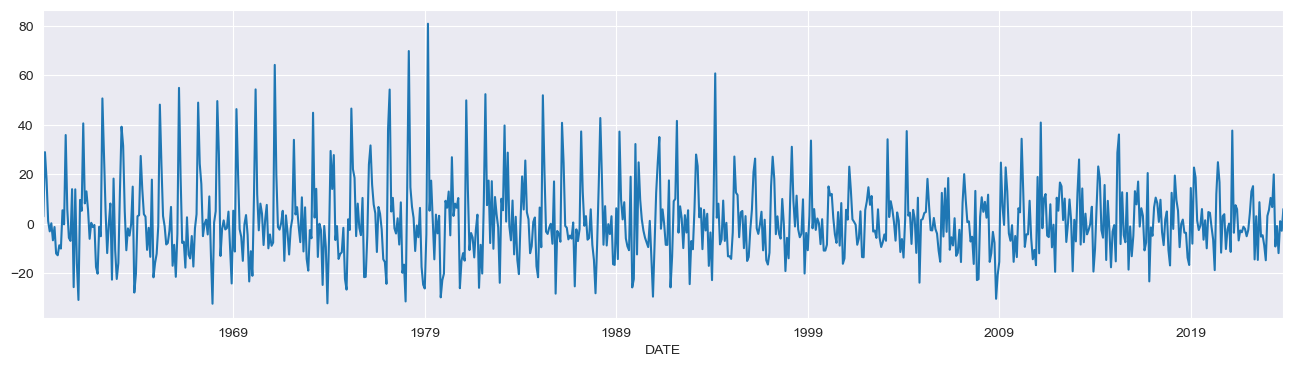

In [3]:
housing = data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq('MS')
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

まずはAR(3)から始めましょう。これはこのデータを表現する良いモデルではありませんが、APIの基本的な使い方を示すために用います。

In [4]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:                     AutoReg(3)   Log Likelihood               -3198.885
Method:               Conditional MLE   S.D. of innovations             15.009
Date:                Wed, 17 Jan 2024   AIC                           6407.770
Time:                        02:40:09   BIC                           6431.034
Sample:                    05-01-1959   HQIC                          6416.720
                         - 11-01-2023                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0998      0.543      2.027      0.043       0.036       2.163
HOUSTNSA.L1     0.1835      0.035      5.211      0.000       0.114       0.253
HOUSTNSA.L2     0.0080      0.036      0.223    

＊基本情報＊

- **依存変数（Dep. Variable）:** `HOUSTNSA`。このモデルが予測する時系列データ。
- **観測数（No. Observations）:** `778`。このモデルが使用するデータポイントの数。
- **モデル（Model）:** `AutoReg(3)`。自己回帰モデルで、3つのラグ（遅れ）を使用しています。
- **方法（Method）:** `Conditional MLE`（条件付き最尤推定法）。
- **標準偏差（S.D. of innovations）:** `15.009`。モデルの誤差項（イノベーション）の標準偏差。
- **日付と時間（Date, Time）:** モデルが実行された日付と時間。
- **AIC, BIC, HQIC:** これらはモデルの適合度を測る情報基準です。一般に、これらの値が小さいほどモデルの適合度が高いとされます。  

    AIC(赤池情報量基準)  
    BIC(ベイズ情報量基準)  
    HQIC(Hannan-Quinn情報量基準)  
    
＊係数（Coef）とその統計＊

- **const:** 定数項の係数。このモデルでは `1.0998`。
- **HOUSTNSA.L1, L2, L3:** それぞれ1期前、2期前、3期前の`HOUSTNSA`の係数。例えば、`HOUSTNSA.L1` の係数は `0.1835` で、前期の値が現在の値に与える影響を示しています。
- **std err:** 係数の標準誤差。
- **z:** Zスコア。係数が統計的に有意かどうかを評価するためのスコア。
- **P>|z|:** 係数が統計的にゼロと異なる確率。通常、0.05以下であれば統計的に有意。
- **[0.025 0.975]:** 係数の95%信頼区間。

＊モデルの根（Roots）＊


1. **実数（Real）と虚数（Imaginary）**:
   ARモデルの解析では、モデルの特性根（characteristic roots）が計算されます。これらは、モデルの安定性や振る舞いを理解するために重要です。実数と虚数の部分は、これらの特性根の構成要素です。実数部分がモデルの振幅を、虚数部分が振動の性質を反映します。

2. **モデュラス（Modulus）**:
   モデュラスは特性根の大きさ（絶対値）を示し、モデルの安定性を評価するために使用されます。一般に、モデルが安定であるためには、すべての特性根のモデュラスが1未満でなければなりません。

3. **周期（Frequency）**:
   周期は、特性根が示す時系列データの循環的な振る舞いの長さを示します。これは、時系列データに含まれる周期的なパターンや波の長さを理解するのに役立ちます。

これらの値は、ARモデルの振る舞いを理解し、モデルがデータのどのような特性を捉えているかを分析するために重要です。特に、時系列データの動的な特性や周期性を評価する際に役立ちます。また、モデルの安定性や予測の信頼性を判断する際にも重要な指標となります。


モデルの「根」は、モデルの動的特性を示します。ここにリストされているのは複素数の根で、モデルが安定しているかどうか、どのような振る舞いを示すかを示します。これらの根が単位円の外側にある場合、モデルは安定とみなされます。

モデルの根が単位円の外側にあるかどうかを判断するには、それらの根の絶対値（modulus）を考慮します。単位円は複素平面上の円で、中心が原点（0,0）で半径が1の円です。モデルの根がこの単位円の外側にある場合、モデルは安定していると考えられます。複素数の根（例：a + bi）の絶対値は、次の式で計算されます：

$$ \text{Modulus} = \sqrt{a^2 + b^2} $$

この絶対値が1より大きい場合、その根は単位円の外側にあります。自己回帰モデルにおいて、全ての根の絶対値が1より大きい場合、そのモデルは安定しているとみなされます。これは、時間が経過するにつれて、モデルの影響が減衰し、時系列が定常状態に収束することを意味します。一方で、1つでも根の絶対値が1以下である場合、モデルは不安定とされ、予測値が発散する可能性があります。すべての絶対値は１より大きいので安定していると言えます。

AutoRegは、OLSと同じ共分散推定器をサポートしています。以下では、Whiteの共分散推定量であるcov_type="HC0 "を使用します。パラメータ推定値は同じですが、標準誤差に依存する量はすべて変化します。

In [5]:
res = mod.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:                     AutoReg(3)   Log Likelihood               -3198.885
Method:               Conditional MLE   S.D. of innovations             15.009
Date:                Wed, 17 Jan 2024   AIC                           6407.770
Time:                        02:40:09   BIC                           6431.034
Sample:                    05-01-1959   HQIC                          6416.720
                         - 11-01-2023                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0998      0.569      1.933      0.053      -0.015       2.215
HOUSTNSA.L1     0.1835      0.034      5.408      0.000       0.117       0.250
HOUSTNSA.L2     0.0080      0.037      0.214    

実際に標準誤差(std err)、z、p値、信頼区間に変化が見られますが、結論を変えるほどではありません。

次のセルの`ar_select_order` 関数と `sel.ar_lags` 属性について解説します。

`ar_select_order` は、自己回帰（AR）モデルにおいて、どのラグ（遅れ）の数が最適であるかを選択するための関数です。これは、時系列データの以前の値が将来の値にどの程度影響を与えるかを分析する際に使用されます。この関数は以下のパラメータを取ります：

- `data`: 時系列データ
- `maxlag`: 考慮される最大のラグ数
- `old_names`: 旧バージョンの出力名を使用するかどうか

例えば、`ar_select_order(housing, 13, old_names=False)` というコードは、`housing` データセットに対して最大13のラグを考慮して、最適なラグ数を選択します。`old_names=False` は、新しい出力名を使用することを意味します。

`sel.ar_lags` は、`ar_select_order` によって返されるオブジェクトの属性で、選択された最適なラグのリストを提供します。この属性は、最適と判断された特定のラグ数を示し、そのラグが自己回帰モデルでどのように使用されるかを決定します。

In [6]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

`sel.ar_lags` が `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]` を返しているので、これは時系列データにおいて1期前から13期前までのデータが現在の値を予測するのに最適であることを意味しています。この情報をもとに、自己回帰モデルはこれらのラグを使用して時系列データの将来の値を予測します。

In [7]:
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:                    AutoReg(13)   Log Likelihood               -2886.312
Method:               Conditional MLE   S.D. of innovations             10.528
Date:                Wed, 17 Jan 2024   AIC                           5802.624
Time:                        02:40:09   BIC                           5872.222
Sample:                    03-01-1960   HQIC                          5829.417
                         - 11-01-2023                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4561      0.448      3.250      0.001       0.578       2.334
HOUSTNSA.L1     -0.2665      0.035     -7.710      0.000      -0.334      -0.199
HOUSTNSA.L2     -0.0833      0.031     -2.69


＊最初のモデル（AutoReg(3)）＊

1. **依存変数:** `HOUSTNSA`。
2. **観測数:** 778。
3. **モデル:** `AutoReg(3)`。3つのラグを使用。
4. **AIC, BIC, HQIC:** これらの値はモデルの適合度を示します。数値が小さいほど良い。
5. **係数:** 
   - **const:** 1.0998（定数項）。
   - **HOUSTNSA.L1:** 0.1835。
   - **HOUSTNSA.L2:** 0.0080。
   - **HOUSTNSA.L3:** -0.1950。

6. **ルーツ:** すべてのルーツの絶対値が1以上で、モデルは安定しています。

＊第二のモデル（AutoReg(13)）＊

1. **依存変数:** `HOUSTNSA`。
2. **観測数:** 778。
3. **モデル:** `AutoReg(13)`。13つのラグを使用。
4. **AIC, BIC, HQIC:** 最初のモデルより数値が小さいため、このモデルの方が適合度が高いと考えられます。
5. **係数:** 13個のラグに対する係数があり、それぞれの影響力が示されています。
6. **ルーツ:** こちらのモデルもすべてのルーツの絶対値が1以上で、安定しています。

＊総合的な解釈＊

- 第二のモデル（AutoReg(13)）は、より多くのラグを使用しており、AIC, BIC, HQICの値が低いため、最初のモデル（AutoReg(3)）よりも適合度が高いと考えられます。
- 両モデルとも安定していますが、第二のモデルがより複雑な時系列のダイナミクスを捉えている可能性があります。
- 係数の値やその統計的有意性（P>|z|の値）を見ると、特定のラグが時系列にどのような影響を与えているかがわかります。例えば、AutoReg(13)モデルでは、HOUSTNSA.L12の係数が大きく、また統計的にも有意です。これは、12期前の値が現在の値に大きな影響を与えていることを示しています。

plot_predictは予測を可視化します。ここでは、モデルによって捕捉された文字列の季節性を示す多数の予測を生成しています。

AutoRegResults.plot_predict(start=None, end=None, dynamic=False, exog=None, exog_oos=None, alpha=0.05, in_sample=True, fig=None, figsize=None)[source]¶

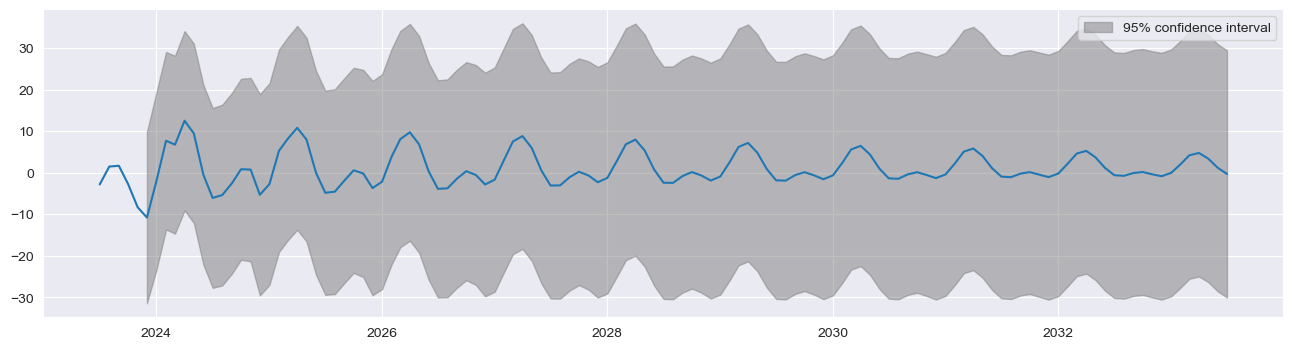

In [8]:
fig = res.plot_predict(len(housing)-5, len(housing)-5+120)

plot_diagnositcsは、モデルがデータの主要な特徴を捉えていることを示します。

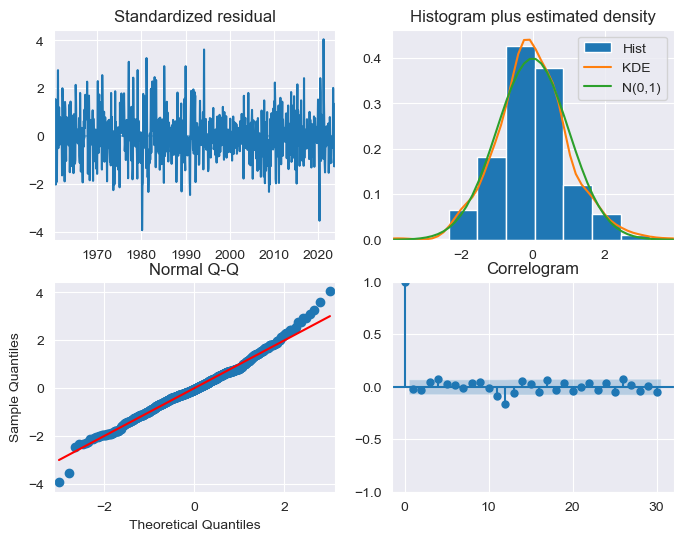

In [9]:
fig = plt.figure(figsize=(8,6))
fig = res.plot_diagnostics(fig=fig, lags=30)

＊季節ダミー＊

AutoRegは季節ダミーもサポートしており、これは季節性をモデル化する別の方法です。ダミーを含めると、ダイナミクスがAR(2)に短縮されます。

In [10]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:               Seas. AutoReg(2)   Log Likelihood               -2871.089
Method:               Conditional MLE   S.D. of innovations              9.786
Date:                Wed, 17 Jan 2024   AIC                           5772.178
Time:                        02:40:09   BIC                           5841.991
Sample:                    04-01-1959   HQIC                          5799.036
                         - 11-01-2023                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5571      1.348      1.155      0.248      -1.085       4.199
s(2,12)        30.9672      1.806     17.149      0.000      27.428      34.506
s(3,12)        19.9295      2.332      8.545    

季節ダミーは、特定の時期（通常は月や四半期）の周期的なパターンを捉えるために使用される変数です。これらの変数は、時系列データが示す季節性の影響をモデル化するために用いられます。たとえば、月次データの場合、各月に対応する12個の季節ダミー変数があり、その月が該当する場合は1、そうでない場合は0の値を取ります。

自己回帰モデルのラグ数を13に指定しましたが、季節ダミーを含めることで、モデルのダイナミクスが変わり、必要なラグの数が減少しました。この場合の「Seas. AutoReg(2)」モデルでは、季節ダミーを含めることにより、最適なラグの数が2つに減少しています。これは、季節ダミーが一部の季節性の影響を捉えるため、それ以外の自己回帰のラグの数を減らすことができるからです。

このモデルでは、季節ダミーが季節性の影響を担い、自己回帰の2つのラグが時系列の他のダイナミクスを捉える役割を果たしています。

＊基本情報＊

- **依存変数（Dep. Variable）:** `HOUSTNSA`。分析対象の時系列データ。
- **観測数（No. Observations）:** 778。データの観測点の数。
- **モデル（Model）:** `Seas. AutoReg(2)`。季節性を考慮した自己回帰モデルで、2つのラグ（遅れ）を使用。
- **方法（Method）:** `Conditional MLE`（条件付き最尤推定法）。
- **標準偏差（S.D. of innovations）:** 9.487。モデルの誤差項の標準偏差。
- **AIC, BIC, HQIC:** モデルの適合度を示す情報基準。数値が小さいほど良い。

＊係数とその統計＊

- **const:** 定数項の係数（1.2726）。
- **s(2,12), s(3,12), ..., s(12,12):** これらは季節ダミー変数の係数で、それぞれ異なる月に対応します（例：s(2,12)は2月、s(3,12)は3月）。これらの係数は季節性の影響を示しており、時系列データに特定の月がどのように影響するかを表します。
- **HOUSTNSA.L1, HOUSTNSA.L2:** 1期前と2期前の`HOUSTNSA`の係数。これらは自己回帰の部分で、過去の値が現在の値にどのように影響するかを示します。

＊根(Roots)＊

- モデルの「根」は、その動的特性を示します。この場合、2つの複素数の根があり、両方とも単位円の外側にあるため、モデルは安定しています。

＊総合的な解釈＊

このモデルは、`HOUSTNSA`データにおける季節性の影響を明確に捉えています。季節ダミー変数の係数は、特定の月がデータに与える影響の大きさと方向を示しており、これらの係数が統計的に有意であるかどうかは、P>|z|の値で確認できます。また、自己回帰部分（HOUSTNSA.L1とL2）も時系列データの過去の値が現在の値に与える影響を示しており、こちらも統計的に有意な係数となっています。全体として、このモデルは季節性と過去のデータポイントの影響を同時に考慮して、`HOUSTNSA`の動向を分析しています。

つぎに、季節ダミーは予測において有効なので、今後10年間のすべての期間において季節成分として取り入れます。

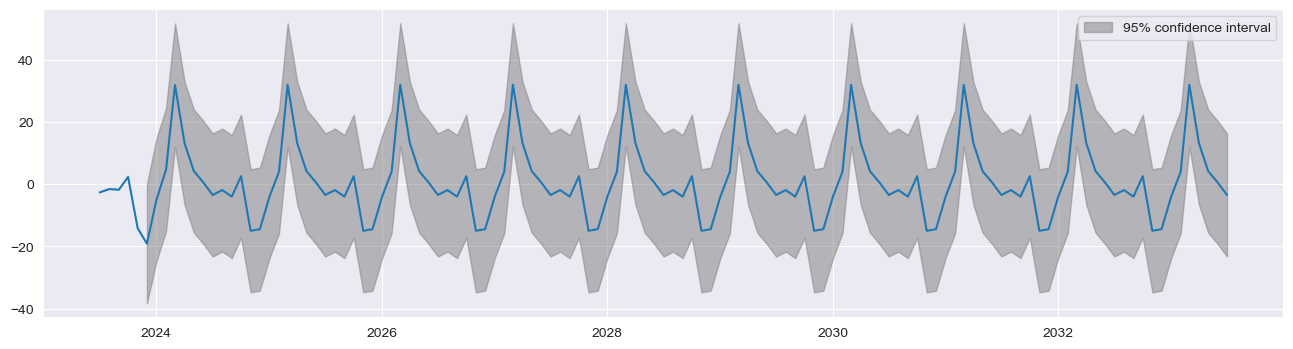

In [11]:
fig = res.plot_predict(len(housing)-5, len(housing)-5+120)

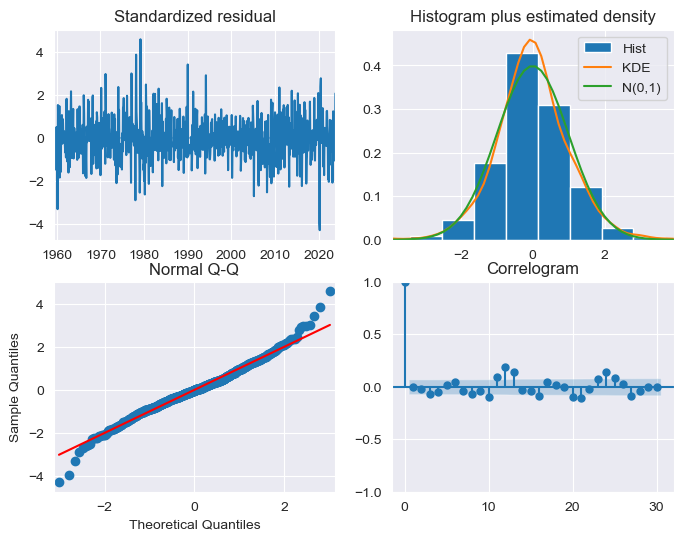

In [12]:
fig = plt.figure(figsize=(8, 6))
fig = res.plot_diagnostics(lags=30, fig=fig)

＊季節ダイナミクス＊

AutoRegはOLS（最小二乗法）を使用してパラメータを推定するため、直接的に季節成分をサポートしていませんが、季節ARの制約を課さない過剰パラメータ化された季節ARを使用することで、季節ダイナミクスを捉えることが可能です。

過剰パラメータ化された季節自己回帰（Seasonal AR）モデルとは、通常の季節自己回帰モデルにおける一般的な制約を設けずに、多数のパラメータを用いて季節性のダイナミクスをモデル化するアプローチです。ここでの「制約を課さない」というのは、モデルが季節的な変動を捉えるために通常適用される特定の数学的な制約や仮定を用いず、より多くのパラメータを使用することを意味します。


季節ARモデルでは通常、特定の周期（例えば、月次データの12ヶ月周期）に基づいてラグを選択し、それらのラグの係数を推定します。このモデルは、季節性が特定の周期で繰り返されるという仮定に基づいています。


過剰パラメータ化された季節ARモデルでは、より多くのラグを使用し、季節性をより柔軟に捉えます。このアプローチでは、通常の季節ARモデルよりも多くのラグを用いて季節性の各側面を詳細にモデル化し、季節性のより微細な変動を捉えることができます。

この方法は、特に季節パターンが単純な年次周期に収まらない複雑な時系列データに有効です。しかし、過剰パラメータ化によってモデルが過学習（過剰適合）を起こすリスクも高まるため、注意深いモデル選択とパラメータの評価が必要です。

```Python
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
```

上述の、`data.HOUSTNSA.pct_change(12)` は `data.HOUSTNSA` 時系列データの各点で、その12ヶ月前の値と比較してどれだけ変化したか（パーセンテージで）を計算します。これにより、年次ベースでの成長率や減少率などを分析することができます。

`resample("MS").last()` はデータを月初（"MS" = month start）に再サンプリングし、各月の最後の観測値を使用することを意味します。そして、`dropna()` により欠損値が除去されます。

このコードは、`HOUSTNSA` データセットの年間パーセンテージ変化を月次でプロットするためのものです。

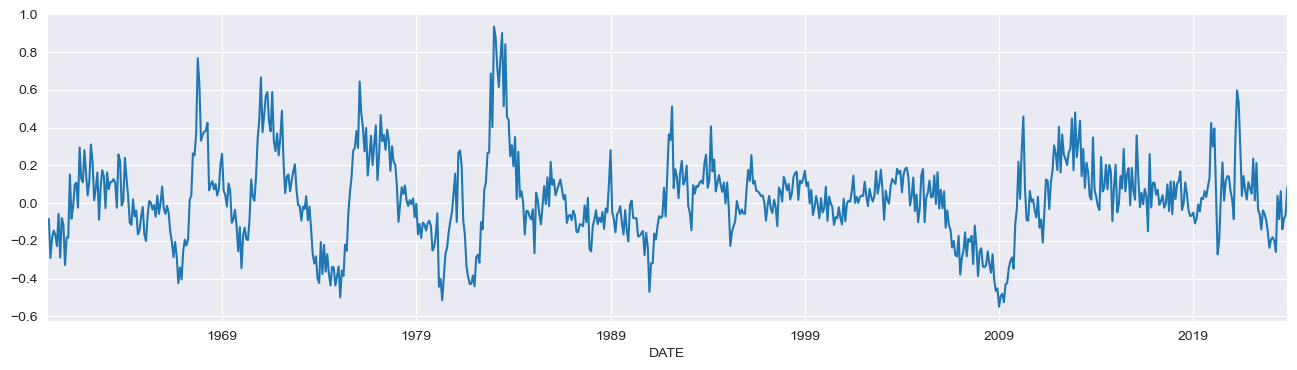

In [13]:
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

最大ラグを選択するだけのシンプルな方法を用いてモデルの選択を始めます。全ての低いラグが自動的に含まれます。最大ラグは13に設定されており、これによりモデルは短期のAR(1)成分と季節性AR(1)成分の両方を持つ季節性ARを考慮することができます。すなわち、

$$ (1-\phi_sL^{12})(1-\phi_1L)y_t=\epsilon_t$$

これは展開すると

$$y_t=\phi_1y_{t-1}+\phi_{s}Y_{t-12}-\phi_{s}Y_{t-13}+\epsilon_t$$

となります。(大文字は最終的に選択されたラグ) AutoRegはこの構造を強制しませんが、入れ子型のモデル

$$y_t=\phi_1y_{t-1}+\phi_{12}Y_{t-12}-\phi_{13}Y_{t-13}+\epsilon_t$$

を推定することができます。

ここでは全13のラグが選択されていることが分かります。

In [14]:
sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

すべての13のラグが必要とは思えません。最大13のラグを含む全ての $2^{13}$ モデルを検索するために、glob=Trueを設定することができます。

ここで、最初の3つが選択され、そして最終的に12番目と13番目が選択されていることが分かります。これは上述の構造と表面的には似ています。

モデルを適用した後、データのダイナミクスを捉えるためにこの仕様が適切であることを示す診断プロットを見てみましょう。

In [15]:
sel = ar_select_order(yoy_housing, 13, glob=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  767
Model:             Restr. AutoReg(13)   Log Likelihood                 605.088
Method:               Conditional MLE   S.D. of innovations              0.108
Date:                Wed, 17 Jan 2024   AIC                          -1196.176
Time:                        02:40:12   BIC                          -1163.798
Sample:                    02-01-1961   HQIC                         -1183.703
                         - 11-01-2023                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0041      0.004      1.023      0.306      -0.004       0.012
HOUSTNSA.L1      0.6019      0.034     17.698      0.000       0.535       0.669
HOUSTNSA.L2      0.2045      0.037      5.53

提供されたAutoRegモデルのサマリーレポートは、13次の制約付き自己回帰（AutoRegressive）モデルの結果を示しています。このモデルでは、13のラグ（遅延）が考慮されており、それらの中で特定のラグ（L1, L2, L3, L12, L13）に対する係数が有意であると判断されています。

モデルのサマリーに含まれる「Roots」セクションは、モデルの特性方程式の根（ルーツ）を示しています。これらの根はモデルの安定性や振る舞いを理解するのに重要です。ARモデルでは、これらの根はモデルのラグ多項式の根として計算されます。

ARモデルの13次までの「モジュラス」が表示されている理由は、モデルが13次の自己回帰成分を持つためです。モデルに含まれるすべてのラグに対応する根（ルーツ）が計算され、それらの根のモジュラス（絶対値）が表示されます。

係数が有意なラグ（L1, L2, L3, L12, L13）がモデルにおいて重要な役割を果たしていることを示していますが、モデルの安定性や振る舞いを理解するためには、すべてのラグに対応する根を考慮することが重要です。これらの根は、モデルがどのように時系列データの過去の値に依存するか、また時間とともにどのように挙動するかを示します。

したがって、特定のラグの係数が有意であっても、モデルの全体的な挙動を理解するためには、すべてのラグに対応する根を検討する必要があります。

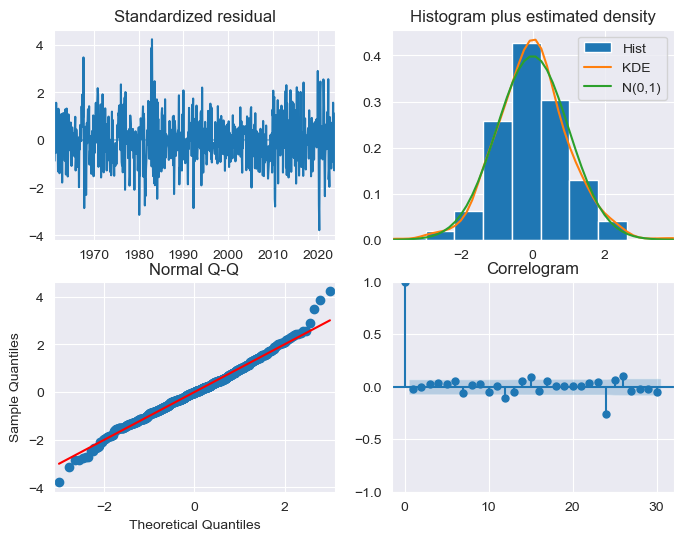

In [16]:
fig = plt.figure(figsize=(8, 6))
fig = res.plot_diagnostics(fig=fig, lags=30)

季節ダミーも含めることができます。しかし、モデルが年間の変化を使用しているため、これらはすべて非有意です。

In [17]:
sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  767
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 606.518
Method:                     Conditional MLE   S.D. of innovations              0.108
Date:                      Wed, 17 Jan 2024   AIC                          -1177.035
Time:                              02:40:17   BIC                          -1093.778
Sample:                          02-01-1961   HQIC                         -1144.962
                               - 11-01-2023                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0147      0.014      1.065      0.287      -0.012       0.042
s(2,12)         -0.0109      0.019     -0.562      0.574      -0.049       0.

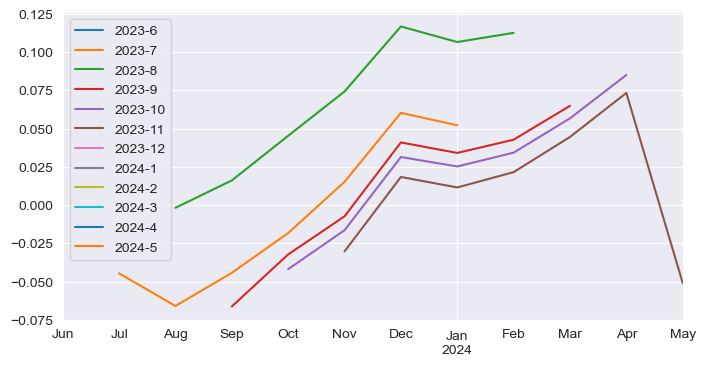

In [18]:
import numpy as np

start = yoy_housing.index[-6]
forecast_index = pd.date_range(start, freq=yoy_housing.index.freq, periods=12)
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)
for i in range(1, 6):
    fcast = res.predict(
        start=forecast_index[i], end=forecast_index[i + 6], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(8, 4))
#yoy_housing.iloc[-6:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)


## 3.2 状態空間方程式

状態空間方程式に関する詳細な説明を行います。

ー状態空間方程式の概要ー

状態空間モデルは、動的システムを観測方程式とシステム方程式の二つの主要な部分で表現します。このモデルは、内生変数と外生変数の両方を含む複雑な時系列データを分析するのに適しています。

ー内生変数と外生変数ー

- **内生変数:** モデル内で説明される変数。例えば、経済成長率や株価指数など、モデルがその振る舞いを説明しようとする変数。
- **外生変数:** モデル外から影響を与える変数。これらはモデル内で直接予測されるわけではなく、他の要因（例えば、政策変更や自然災害など）によって決定されます。

ー時系列分析における方程式ー

時系列データが単変量の場合、一般的には一つの変数に注目しますが、多変量（ベクトル）の場合は複数の関連する時系列データを同時に考慮します。ラグを取る場合、過去の値が現在の値に影響を与えるという時間的依存性をモデルに組み込みます。

＊問題点＊

- **多変量データ:** 複数の時系列を扱う場合、変数間の相互依存性がモデルの複雑性を増加させる。
- **ラグの取り扱い:** ラグを多く取りすぎると、モデルが過度に複雑になり、過学習のリスクが生じる。
- **外生変数の影響:** 外生変数の変化が予測できない場合、モデルの予測精度に影響を与える可能性がある。

ー観測方程式とシステム方程式の分離ー

- **観測方程式:** モデルの観測されたデータと内部状態との関係を定義します。この方程式は、観測データがどのように内部状態から生成されるかを示します。
- **システム方程式:** モデルの内部状態の進化を表します。この方程式は、時系列データの内部ダイナミクスを表現します。


$$ y_t = C_t x_t + D_t u_t + \epsilon_t $$
$$ x_{t+1} = A_t x_t + B_t u_t + \eta_t $$

ここで、$ y_t $ は観測されたデータ、$ x_t $ は状態変数、$ u_t $ は外生入力、$ \epsilon_t $ と $ \eta_t $ はそれぞれ観測と状態の誤差項です。

＊残差、メリット、デメリット＊

- **複数の残差:** 状態空間モデルでは、観測誤差とシステム誤差の両方が存在します。これにより、データのノイズとシステムの不確実性をより詳細にモデル化できます。
- **メリット:** 複雑なダイナミクスと複数のデータソースを統合する能力。
- **デメリット:** モデルの設定と推定が複雑になる可能性があります。

ー最尤法とその他の推定方法ー

- **最尤法:** 多くの場合、状態空間モデルは最尤法を用いて推定されます。これには、残差が特定の分布（通常は正規分布）に従うという仮定が含まれることが多いです。
- **分布の仮定:** 異なる分布の仮定を行うことも可能ですが、その場合、モデルの複雑さと計算時間が増加する可能性があります。例えば、残差が非正規分布に従う場合、推定方法はより複雑な非線形最適化技術を要求することがあります。

- **最尤法を使わない推定:** 最尤法以外にも、ベイズ推定や一般化モーメント法（GMM）など、状態空間モデルを推定するための代替手法が存在します。これらの方法は、異なる統計的性質を持ち、特定の状況下での利点があります。


ー**statsmodels**ー

Statsmodelsでは状態空間方程式のクラスとして、Unobserved Component Analysis（UCA）とSARIMAXモデル、また、Regime Switching Model、Vector Autoregressive Moving Average（VARMA）モデルDynamic Factor Modelを用意しています。

ーUnobserved Component Analysis (UCA)ー

UCAは、時系列データの中に存在するが直接観測されない成分（例えば、トレンド、季節性、サイクル）を識別し、分析するために使用されます。このアプローチでは、データは複数の潜在的な成分に分解され、それぞれが独自の特性と動的な挙動を持っています。

- **メリット:** トレンドや季節性などの特定の成分を明確に分離し、それぞれの成分の挙動を個別に分析できる。
- **デメリット:** 潜在的な成分の数や性質を仮定する必要があり、これが正確でない場合、分析結果が歪む可能性がある。

ーSARIMAXモデルー

SARIMAXモデルは、「季節性自己回帰積分移動平均 with eXogenous variables」の略で、内生変数の時系列データに季節性要素と外生変数を組み込んだモデルです。SARIMAXは自己回帰（AR）、移動平均（MA）、差分積分（I）、季節性成分、および外生変数を統合して、より複雑なデータ構造をモデル化します。

- **メリット:** 季節性パターンと外部からの影響（例えば経済政策や気候変動など）を統合し、より複雑な時系列データを正確に予測・分析できる。
- **デメリット:** モデルの複雑性が高く、適切なパラメータを選択するのが難しい。また、過剰適合のリスクがある。

＊ラグ多項式のメリットとデメリット＊

ラグ多項式は、時系列データの過去の値が現在の値にどのように影響するかを表すために使用されます。

- **メリット:** ラグ多項式を使用することで、解析が複素平面に拡張され、システムの安定性や振る舞いをより深く理解することができます。例えば、ルーツが単位円の外側にある場合、システムは安定とみなされます。
- **デメリット:** ラグ多項式が複雑になるほど、モデルの解釈と推定が難しくなります。また、適切なラグの長さを選択することが重要で、選択が不適切な場合にはモデルの過学習や不安定性を引き起こす可能性があります。

＊ラグ多項式の使用による複雑化＊

- **複素平面の利用:** ラグ多項式の根が複素平面にある場合、それによってモデルの動的な特性（振動や減衰など）をより詳細に理解することが可能になります。
- **安定性の分析:** 複素根が特定の領域（例えば単位円の外側）にある場合、モデルの安定性に関する洞察を得ることができます。

ーRegime Switching Modelー

Regime Switching Modelは、時系列データが異なる「レジーム」または状態によって異なる挙動を示すことをモデル化します。ここでの「レジーム」は異なる時期や状況を指し、それぞれのレジームは独自のパラメータセットを持ちます。

- **内生変数:** 時系列データ自体（例：GDP、株価指数など）。
- **外生変数:** レジーム変更を引き起こす可能性のある要因（例：政策変更、主要な経済指標の発表など）。

このモデルは、特に経済データが異なる経済サイクルや市場の状態によって異なる動的プロセスに従う場合に有用です。レジームの変更は、内生変数のパターンの変化を引き起こす外生的な出来事によって引き起こされる場合があります。

ーVector Autoregressive Moving Average (VARMA) モデルー

VARMAモデルは、複数の関連する時系列が互いにどのように影響し合うかを分析します。

- **内生変数:** 分析対象の複数の時系列データ（例：異なる国のGDP成長率、複数の株価指数など）。
- **外生変数:** 各時系列に影響を与える可能性のある外部からの要因（例：国際的な経済政策、市場の全体的な動向など）。

VARMAモデルは、時系列間の動的な関連性と影響を捉えるために使用されます。このモデルは、特に複数の時系列間の複雑な相互作用を分析する際に役立ちます。

ーDynamic Factor Modelー

Dynamic Factor Modelは、大量の時系列データがいくつかの共通の隠れた要因によって駆動されているという考えに基づいています。

- **内生変数:** 多数の時系列データ（例：様々な産業の株価、地域ごとの経済指標など）。
- **外生変数:** 共通の要因に影響を与える可能性のある外部要因（例：グローバルな経済トレンド、政治的な出来事など）。

このモデルは、大量の時系列データに含まれる共通の動きやパターンを抽出することに焦点を当てています。これにより、複数のデータソースから情報を統合し、より包括的な経済や市場の動向を理解することができます。

ー状態空間モデルの全体像ー

状態空間モデルは、時系列データの複雑なダイナミクスを理解するための強力なフレームワークを提供します。内生変数と外生変数の両方を考慮することにより、経済、金融、社会科学、工学など多岐にわたる分野において、現実のデータに基づいた洞察を得ることが可能になります。総じて、状態空間モデルは時系列データの分析において柔軟かつ強力なツールです。


ただし、これらのモデルの適用には、統計的な仮定、複雑さ、計算コストなどの考慮が必要です。そのため、モデルの選択、パラメータの推定、および解釈には慎重さが求められます。また、モデルの複雑性とデータの性質に応じた適切な推定方法の選択が重要です。

### 3.2.1 非観測成分分析(Unobserved Component Analysis

これらは構造時系列モデルとしても知られており、（単変量の）時系列をトレンド、季節性、周期性、不規則な成分に分解します。（詳細は[1]の第3.2章を参照）一般的な形式は

$$ y_t=\mu_t+\gamma_t+c_t+\varepsilon_t$$

です。ここで、$y_t$は時刻$t$における観測ベクトル、$\mu_t$はトレンド成分、$\gamma_t$は季節成分、$c_t$は周期、$\varepsilon_t$は不規則成分を指します。これらの成分の基本はローカルとレベルという概念です。

ーローカルー

「ローカル」という用語は、各時点や各期間に特有の、時系列データの局所的な特徴や動きを指します。これはレベルとその他の成分を考える際の基準になります。

ーレベルー

時系列データにおけるレベル成分は、基本的にデータの「基準線」または「開始点」を指します。レベルは確定的な値として設定することもできますし、時間の経過とともに変化していく確率的なものとも捉えることができます。その見直しはローカルに行われます。これは以下のように書かれます：

$$\mu_t=\mu_{t-1}+\eta_{t-1}$$

ここで、$\eta_t \sim N(0,\sigma_\eta^2)$です。ここでのレベルは時間を通じて動的に変化することができる切片項の一般化です。レベルはトレンドや他の動的成分の解釈に影響を与えます。この概念を理解することで、トレンドや季節性、周期性成分の動きがより明確になります。


ートレンドー

トレンド成分は、切片と線形時間トレンドを含む回帰モデルの動的拡張です。時間トレンドは時間の経過とともに一定の割合でレベルが変化していきますが、トレンドは確率的に変化することもできます。これは以下のように書かれます：

$$\mu_t=\mu_{t-1}+\beta_{t-1}+\eta_{t-1}$$
$$\beta_t=\beta_{t-1}+\zeta_{t-1}$$

トレンドは時間を通じて傾きが動的に変化することができる時間トレンドの一般化です。ここで、 $\zeta_t \sim N(0,\sigma_\zeta^2)$です。

ーlevel(string)ー

UnobservedComponentsクラスでは引数levelに指定された文字列を入れることでレベルやトレンドといったモデルの要素を指定することができます。

＊ローカルレベルモデル（Harvey (1989) のセクション4.2を参照）＊

ローカルレベルモデルは次のように書くことができます。

$$Y_t=\alpha_t+\varepsilon_t, \; \; \; \varepsilon_t \sim N(0,\sigma_\varepsilon^2)$$
$$\alpha_{t+1}=\alpha_t+\eta_t, \;\;\; \eta_t \sim N(0,\sigma_\eta^2)$$

これは
```Python
output_mod = sm.tsa.UnobservedComponents(data,level='local level')
```
と指定することで済みます。level='llevel'と短縮して書くこともできます。

＊ローカル線形トレンドモデル

ローカル線形トレンドモデルは以下の形式を持ちます（詳細な表記と説明についてはDurbinとKoopman 2012, 第3.2章を参照）：

$$\begin{array}{ll}
    y_t=\mu_t+\varepsilon_t & \varepsilon_t \sim N(0,\sigma_\varepsilon^2)\\
    \mu_{t+1}=\mu+\nu_t+\xi & \xi_t \sim N(0,\sigma_\xi^2)\\
    \nu_{t+1}=\nu_t+\zeta_t & \zeta_t \sim N(0,\sigma_\xi^2)
\end{array}
$$

このモデルを状態空間形式に置き換えることは容易です。状態空間表現の多くは既知の値で構成されていることに注意してください：

$$\begin{array}{ll}
y_t&=\begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix} \mu_t\\\nu_t\end{pmatrix}+ \varepsilon_t\\
\begin{pmatrix}\mu_{t+1}\\\nu_{t+1} \end{pmatrix} &=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix}\begin{pmatrix}\mu_{t}\\\nu_{t+1} \end{pmatrix}+\begin{pmatrix}\xi_{t}\\ \zeta_{t} \end{pmatrix}
\end{array}$$

実際、推定されるパラメータが現れるのは分散/共分散行列の部分だけです：

$$\begin{array}{ll}
H_t &=\begin{bmatrix}\sigma_\varepsilon^2 \end{bmatrix}\\
Q_t &=\begin{bmatrix}\sigma_\xi^2 &0 \\ 0& \sigma_\zeta^2\end{bmatrix}
\end{array}$$

これらの方程式はカルマンフィルターと最尤推定法を用いて分散/共分散行列を推定されます。しかし、UnobservedComponentsクラスでは、これはプログラミングすることなく
```Python
output_mod = sm.tsa.UnobservedComponents(data,level='local linear trend')
```
とすればよいのです。

つぎに実行可能な代表的なモデルを表示します。

|モデル名|指定文字列|短縮文字列|モデル|
|:-:|:-:|:-:|:-:|
|ローカルレベル|'local level'|'llevel'|𝑦𝑡=𝜇𝑡+𝜀𝑡|
||||𝜇𝑡=𝜇𝑡−1+𝜂𝑡|
|ランダムウォーク(RW)|'random walk'|'rwalk'|𝑦𝑡=𝜇𝑡|
||||𝜇𝑡=𝜇𝑡−1+𝜂𝑡|
|ドリフト付きRW|'random walk with trend'|'rwdrift'|𝑦𝑡=𝜇𝑡|
||||𝜇𝑡=𝜇𝑡−1+𝛽+𝜂𝑡|
|ローカル線形トレンド|'local linear trend'|'lltrend'|𝑦𝑡=𝜇𝑡+𝜀𝑡|
||||𝜇𝑡=𝜇𝑡−1+𝛽𝑡−1+𝜂𝑡|
||||𝛽𝑡=𝛽𝑡−1+𝜁𝑡|

モデルにおいてレベル（$\mu_t$）とトレンド（$\beta_t$）は重要な構成要素です。これらの成分は、時系列データの基本的な傾向や動きを表しています。モデルを適用した後、これらの観測されない成分の推定値が、結果クラスの属性として利用可能になります。

ー季節性（時間領域）ー

季節性成分は以下のようにモデル化されます：

$$\gamma_t=-\sum_{j=1}^{s-1} \gamma_{t+1-j}+w_t$$
$$w_t \sim N(0,\sigma_w^2)$$

周期性（季節の数）はsであり、定義上の特徴は（誤差項なしでは）、季節性成分が1サイクルを通じてゼロになることです。誤差項の含有により、季節性効果が時間を通じて変動することが可能です(これが望ましくない場合、$\sigma_w^2$をstochastic_seasonal=Falseキーワード引数を使用してゼロに設定できます)。

パラメータとして季節の数$s$を選択し、最尤法を通じてパラメータ$\sigma_w^2$を推定します。

ー周波数領域の季節性ー

各周波数領域の季節性成分は以下のようにモデル化されます：

$$\gamma_t=\sum_{j=1}^h \gamma_{j,t}$$
$$\gamma_{j,t+1}=\gamma_{j,t}\cos(\lambda_j)+\gamma_{j,t}^*\sin(\lambda_j)+w_{j,t}$$
$$\gamma_{j,t+1}^*=-\gamma_{j,t}\sin(\lambda_j)+\gamma_{j,t}^*\cos(\lambda_j)+w_{j,t}^*$$
$$w_{j,t}^*,w_{j,t} \sim N(0,\sigma_{w^2})$$
$$\lambda_j=\frac{2\pi j}{s}$$ 

ここで、$j$は1から$h$までの範囲です。

周期性（「季節」の数）は$s$であり、ハーモニクスの数は$h$です。$h$は$s/2$未満に設定することができますが、$s/2$のハーモニクスで周期性sの全ての季節変動を完全にモデル化するのに十分です。時間領域の季節成分と同じように、誤差項の含有により季節効果が時間を通じて変動することが可能です。stochastic_freq_seasonal引数を使用して、このタイプの季節成分の一つまたは複数を非ランダムに設定できます。ここでハーモニクスは基本波（原信号の基本周波数）の整数倍の周波数のことです。

季節の数$s$と、オプションでハーモニクスの数$h$$1\le h \le \lfloor s/2 \rfloor$を選択します。最尤法を使用して適合させるパラメータは$\sigma_{w^2}$です。

ー周期成分(サイクル)ー

周期成分は、季節成分よりもはるかに長い時間枠の周期効果を捉えることを目的としています。例えば、経済学では、周期成分はしばしばビジネスサイクルを捉えるために使用され、その期間は「1.5年から12年」とされています（Durbin and Koopmanを参照）。

$$c_{t+1}=\rho_c(\bar{c}_t\cos \lambda_c t + \bar{c}_t^* \sin \lambda_c) + \tilde{w}_t$$
$$c_{t+1}^*=\rho_c(-\bar{c}_t\sin \lambda_c t + \bar{c}_t^* \cos \lambda_c) + \tilde{w}_t^*$$

ここで、$w_t,\tilde{w}_t$  iid $N(0,\sigma_{\tilde{w}}^2)$

パラメータ$\lambda_c$（サイクルの周波数）は、MLEによって推定される追加のパラメータです。

周期効果が確率的である場合（stochastic_cycle=True）、誤差項の分散（両方の誤差項は同じ分散を共有しますが、独立した抽出が仮定されています）を推定する別のパラメータがあります。

サイクルが減衰する場合（damped_cycle=True）、$\rho_c$を推定する第三のパラメータが必要です。

適切な周波数のサイクルを達成するために、$\lambda_c$の推定には制限が課されます。これらは、cycle_period_boundsキーワード引数を使用して制御できます。指定された場合、期間の上下限（下限、上限）のタプルでなければなりません。その後、周波数の制限はこれらの制限から計算されます。


ー不規則成分ー

不規則成分は独立同一分布（iid）です：
$$\varepsilon_t \sim N(0,\sigma_\varepsilon^2)$$

＊自己回帰的不規則＊

自己回帰成分（しばしばホワイトノイズの不規則項の代わりとして使用される）は以下のように指定できます：

$$\varepsilon_t =\rho(L)\varepsilon_{t-1}+\epsilon_t$$
$$\epsilon_t \sim N(0,\sigma_\epsilon^2)$$


ー回帰効果ー

外生回帰因子はexog引数に渡します。回帰係数は最尤法によって推定されますが、mle_regression=Falseの場合、回帰係数は状態ベクトルに含まれ、本質的に再帰的なOLSを通じて推定されます。

参考文献

[1]
Durbin, James, and Siem Jan Koopman. 2012. Time Series Analysis by State Space Methods: Second Edition. Oxford University Press.

In [20]:
dta=housing

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

このモデルには2つのパラメーターがあり、選択する必要があります：var.level ($\sigma_\eta^2$) および var.irregular ($\sigma_\varepsilon^2$)。尤度関数を数値的に最大化することで、組み込みのfitメソッドを使用してこれらを選択できます。

私たちの例では、ローカルレベルモデルを住宅着工件数のインフレーションに適用しています。

In [22]:
#dta = sm.datasets.macrodata.load_pandas().data
#dta.index = pd.date_range(start='1959Q1', end='2009Q4', freq='Q')

output_mod = sm.tsa.UnobservedComponents(dta,level='local level')
output_res = output_mod.fit(method='powell', disp=False)

print(output_res.summary())

                        Unobserved Components Results                         
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:                    local level   Log Likelihood               -3240.519
Date:                Wed, 17 Jan 2024   AIC                           6485.038
Time:                        02:40:18   BIC                           6494.349
Sample:                    02-01-1959   HQIC                          6488.620
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   243.3875      8.360     29.115      0.000     227.003     259.772
sigma2.level      1.392e-17      0.010   1.37e-15      1.000      -0.020       0.020
Ljung-Box (L1) (Q):         

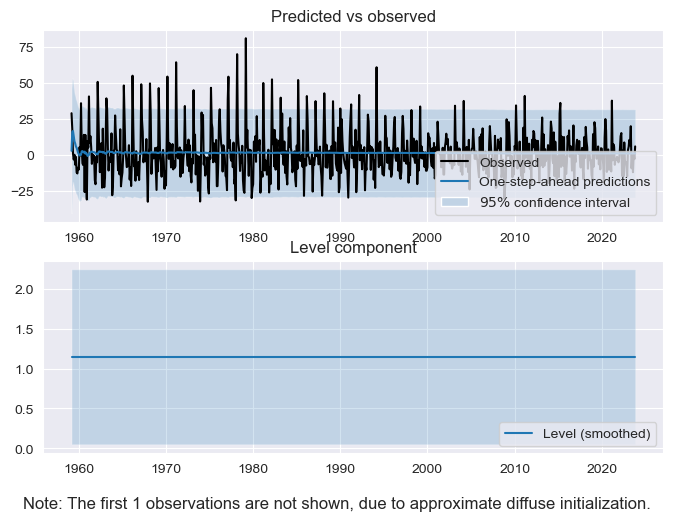

In [23]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(8, 5.5));

                        Unobserved Components Results                         
Dep. Variable:               HOUSTNSA   No. Observations:                  778
Model:             local linear trend   Log Likelihood               -3245.375
Date:                Wed, 17 Jan 2024   AIC                           6496.750
Time:                        02:40:19   BIC                           6510.713
Sample:                    02-01-1959   HQIC                          6502.122
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   243.5327      8.207     29.673      0.000     227.447     259.619
sigma2.level      3.083e-10      0.168   1.83e-09      1.000      -0.330       0.330
sigma2.trend      7.505e-17 

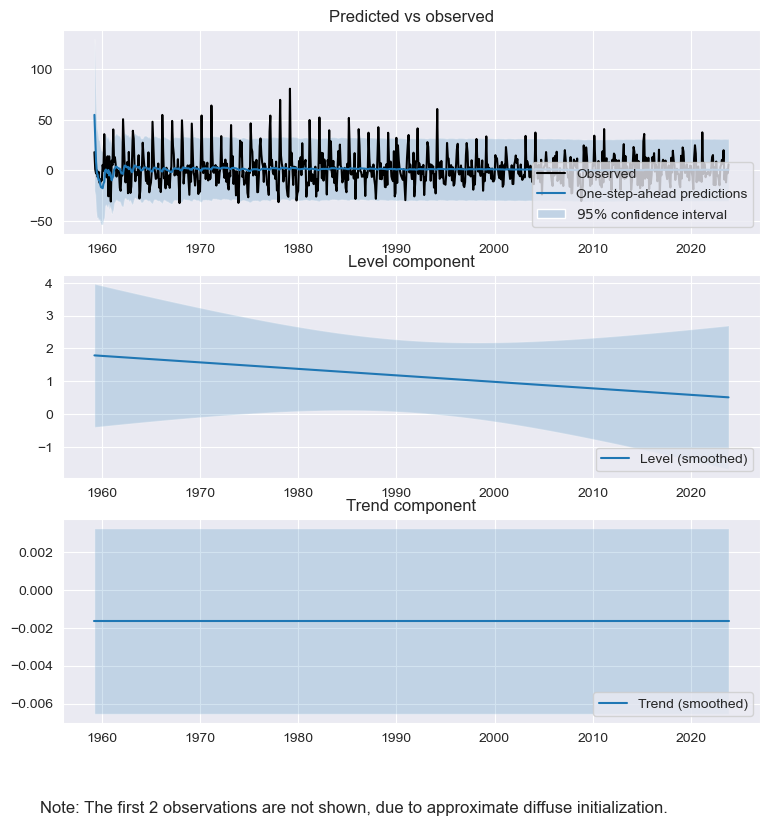

In [24]:
output_mod = sm.tsa.UnobservedComponents(dta,level='local linear trend')
output_res = output_mod.fit(method='powell', disp=False)

print(output_res.summary())

fig = output_res.plot_components(legend_loc='lower right', figsize=(9, 9));

                            Unobserved Components Results                            
Dep. Variable:                      HOUSTNSA   No. Observations:                  778
Model:                           local level   Log Likelihood               -2796.850
                   + stochastic seasonal(12)   AIC                           5649.701
                                    + AR(24)   BIC                           5779.654
Date:                       Wed, 17 Jan 2024   HQIC                          5699.725
Time:                               02:41:03                                         
Sample:                           02-01-1959                                         
                                - 11-01-2023                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

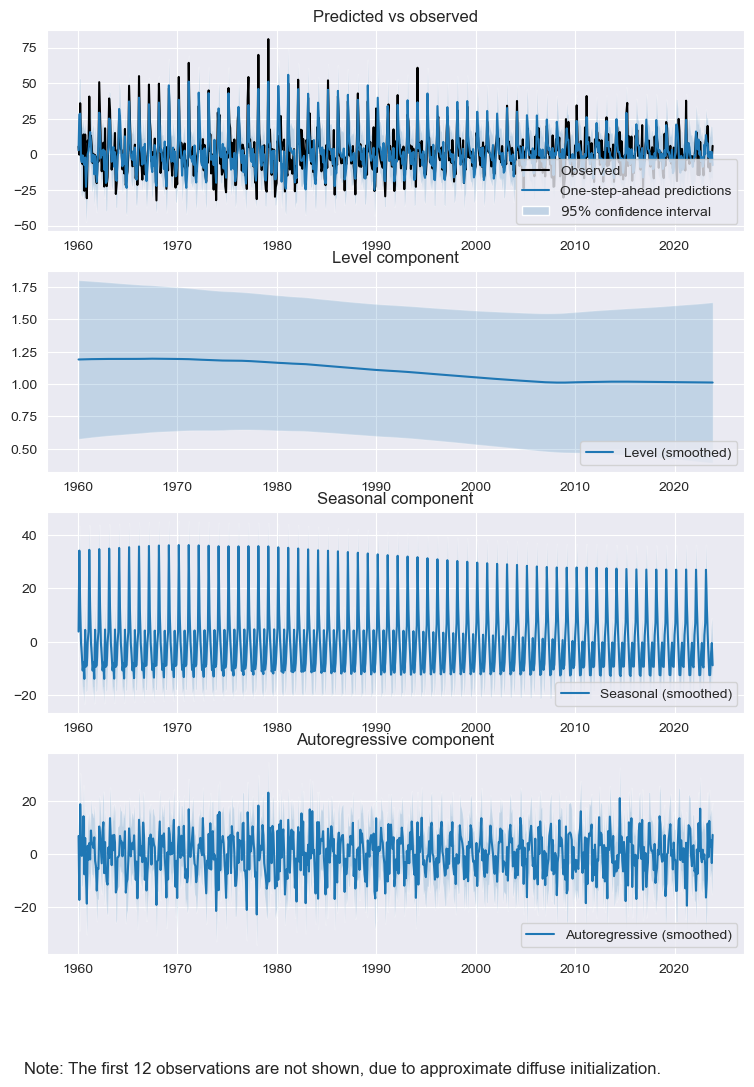

In [25]:
output_mod = sm.tsa.UnobservedComponents(dta,level=True, trend=False, seasonal=12, 
                                         freq_seasonal=None, cycle=False, autoregressive=24, 
                                         irregular=True, stochastic_level=True, stochastic_trend=False, 
                                         stochastic_seasonal=True, stochastic_freq_seasonal=None, 
                                         stochastic_cycle=False, damped_cycle=False, 
                                         cycle_period_bounds=None, mle_regression=True, use_exact_diffuse=False,)
output_res = output_mod.fit(method='powell', disp=False)

print(output_res.summary())

fig = output_res.plot_components(legend_loc='lower right', figsize=(9, 12));

### 3.2.2 SARIMAX

SARIMAモデルは $(p,d,q)\times (P,D,Q)_s$ で指定されます。

ー$(p,d,q)$ー

- **p:** 自己回帰（AR）の項の数。これは時系列が過去の自分自身の値にどの程度依存しているかを示します。
- **d:** 差分（I）の回数。これは時系列を定常にするために必要な差分の数です。
- **q:** 移動平均（MA）の項の数。これは時系列が過去の予測誤差にどの程度依存しているかを示します。

ー$(P,D,Q)_s$ー

- **P:** 季節性自己回帰（Seasonal AR）の項の数。
- **D:** 季節性差分の回数。これは時系列の季節性成分を定常にするために必要な差分の数です。
- **Q:** 季節性移動平均（Seasonal MA）の項の数。
- **s:** 季節性周期。たとえば、月次データの場合は12（1年間に12ヶ月）、四半期データの場合は4（1年間に4四半期）です。

したがって、SARIMAX $(p,d,q)\times (P,D,Q)_s$ モデルは、非季節性成分（AR、I、MA）と季節性成分（Seasonal AR、Seasonal I、Seasonal MA）の両方を組み合わせ、外生変数（exogenous variables）を含む複雑な時系列モデルを形成します。つぎにSARIMAモデルの数学的な表現を示します。

$$\phi_p(L)\tilde{\phi}_P(L^s)\Delta^d\Delta_s^Dy_t=A(t)+\theta_q(L)\tilde{\theta}_Q(L^s)\zeta_t$$

ー各項の意味ー

1. **$\phi_p(L)$:** 自己回帰（AR）部分のラグ多項式。ここで、$L$ はラグ演算子（過去の値を指す）で、$p$ は非季節性AR部分の順位（ラグの数）を示します。

2. **$\tilde{\phi}_P(L^s)$:** 季節性自己回帰部分のラグ多項式。$L^s$ は季節性ラグ演算子で、$s$ は季節周期（例：月次データでは12）、$P$ は季節性AR部分の順位を示します。

3. **$\Delta^d$:** 差分演算子。$d$ 回の差分を取ることで、時系列を定常にします。

4. **$\Delta_s^D$:** 季節性差分演算子。季節性の成分を定常にするために、$D$ 回の季節性差分を取ります。

5. **$y_t$:** 時点 $t$ での時系列データ。

6. **$A(t)$:** 時点 $t$ での決定論的トレンドまたは外生入力（例：外生変数やダミー変数）。

7. **$\theta_q(L)$ と $\tilde{\theta}_Q(L^s)$:** 非季節性と季節性移動平均（MA）部分のラグ多項式。それぞれ$q$ と $Q$ は非季節性と季節性MA部分の順位を示します。

8. **$\zeta_t$:** 時点 $t$ での誤差項。

この式は、時系列データの現在の値が過去の値（自己回帰部分）、過去の誤差（移動平均部分）、季節的変動、および任意の決定論的または外生的要因によってどのように影響されるかをモデル化しています。SARIMAモデルは、非季節性要素と季節性要素の両方を捉えるため、複雑な時系列パターンを持つデータの分析に適しています。

ー単変量の構造モデルー

単変量の構造モデルの観点から、これは以下のように表されます。
$$y_t=u_t+\eta_t$$
$$\phi_p(L)\tilde{\phi}_P(L^s)\Delta^d\Delta_s^Du_t=A(t)+\theta_q(L)\tilde{\theta}_Q(L^s)\zeta_t$$

ここで、$\eta_t$ は測定誤差の場合にのみ適用されます（ただし、p=q=0の純粋な回帰モデルの場合にも使用されます）。

この形式では、時系列データ $ y_t $ が二つの主要な成分に分けられます：構造成分 $ u_t $ と測定誤差 $ \eta_t $。

1. **$ y_t = u_t + \eta_t $:**
   - $ y_t $：時点 $ t $ での観測された時系列データ。
   - $ u_t $：時系列の構造成分、つまり真の（観測されていない）データの値。
   - $ \eta_t $：時点 $ t $ での測定誤差。これは、観測値と構造成分との間の誤差を表します。

2. **SARIMAモデルの式（構造成分 $ u_t $ に適用）:**
   - $ \phi_p(L)\tilde{\phi}_P(L^s)\Delta^d\Delta_s^Du_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)\zeta_t $：
     - この式は、構造成分 $ u_t $ がSARIMAプロセスに従うことを示しています。
     - $ \phi_p(L), \tilde{\phi}_P(L^s), \Delta^d, \Delta_s^D $ は、非季節性および季節性の自己回帰（AR）と差分成分を表します。
     - $ A(t) $：時点 $ t $ での外生入力やトレンド。
     - $ \theta_q(L), \tilde{\theta}_Q(L^s) $ は、非季節性および季節性の移動平均（MA）成分を表します。
     - $ \zeta_t $：構造成分の誤差項。

＊測定誤差の役割＊

- 測定誤差 $ \eta_t $ は、モデルが単に回帰モデル（p=q=0）である場合、または観測データに誤差が含まれる場合にのみ適用されます。
- SARIMAモデルは、基本的に時系列の構造成分 $ u_t $ がどのように進化するかをモデル化しており、測定誤差 $ \eta_t $ はこの構造から生じる観測値の偏差を表します。

この構造モデルの表現は、時系列データの観測値が、SARIMAプロセスによってモデル化された内在的なダイナミクスと、測定時のランダムな誤差によって影響を受けることを示しています。

このモデルの観点から、SARIMAエラーを伴う回帰は簡単に以下のように表されます。

$$y_t=\beta_tx_t+u_t$$
$$\phi_p(L)\tilde{\phi}_P(L^s)\Delta^d\Delta_s^Du_t=A(t)+\theta_q(L)\tilde{\theta}_Q(L^s)\zeta_t$$

このモデルは外生回帰係数が提供される場合に使用されます。

1. **$ y_t = \beta_t x_t + u_t $:**
   - $ y_t $：時点 $ t $ での観測された時系列データ。
   - $ \beta_t $：時点 $ t $ での外生変数 $ x_t $ の回帰係数。
   - $ x_t $：時点 $ t $ での外生変数（説明変数）。
   - $ u_t $：時系列の構造成分、つまり真の（観測されていない）データの値で、SARIMAプロセスに従います。

2. **SARIMAプロセスの式（構造成分 $ u_t $ に適用）:**
   - $ \phi_p(L)\tilde{\phi}_P(L^s)\Delta^d\Delta_s^Du_t = A(t) + \theta_q(L)\tilde{\theta}_Q(L^s)\zeta_t $：
     - この式は、構造成分 $ u_t $ がSARIMAプロセスに従うことを示しています。
     - $ \phi_p(L), \tilde{\phi}_P(L^s), \Delta^d, \Delta_s^D $ は、非季節性および季節性の自己回帰（AR）と差分成分を表します。
     - $ A(t) $：時点 $ t $ での外生入力やトレンド。
     - $ \theta_q(L), \tilde{\theta}_Q(L^s) $ は、非季節性および季節性の移動平均（MA）成分を表します。
     - $ \zeta_t $：構造成分の誤差項。

- このモデルは、時系列データが外生変数によって部分的に説明される場合に使用されます。
- 外生変数の影響を考慮した上で、残りの変動性（$ u_t $）がSARIMAプロセスによってモデル化されます。
- このアプローチは、外生変数と時系列のダイナミクスの両方を同時に考慮するために有用です。

ー簡略化されたラグ多項式の式ー

簡略化された形のラグ多項式は以下のように記述されます：

$$\Phi(L)\equiv \Phi_p(L)\tilde{\phi}_P(L^s)$$
$$\Theta(L)\equiv \theta_q(L)\tilde{\theta}_Q(L^s)$$

SARIMAモデルは、自己回帰（AR）、差分（I）、移動平均（MA）の要素に加えて、これらの季節性バージョンも含んでいます。簡略化された形のラグ多項式は、モデルのこれらの要素を統合した形を示しています。

1. **自己回帰部分のラグ多項式:**
   $$\Phi(L) \equiv \Phi_p(L)\tilde{\phi}_P(L^s)$$
   - $ \Phi(L) $：総合的な自己回帰部分のラグ多項式。
   - $ \Phi_p(L) $：非季節性自己回帰部分のラグ多項式。
   - $ \tilde{\phi}_P(L^s) $：季節性自己回帰部分のラグ多項式。
   - $ L $：ラグ演算子。
   - $ L^s $：季節性ラグ演算子（$ s $ は季節周期）。

2. **移動平均部分のラグ多項式:**
   $$\Theta(L) \equiv \theta_q(L)\tilde{\theta}_Q(L^s)$$
   - $ \Theta(L) $：総合的な移動平均部分のラグ多項式。
   - $ \theta_q(L) $：非季節性移動平均部分のラグ多項式。
   - $ \tilde{\theta}_Q(L^s) $：季節性移動平均部分のラグ多項式。

＊ラグ多項式の意味＊

- これらの多項式は、モデルが過去の観測値と誤差項の影響をどのように統合して現在の値を計算するかを表します。
- 自己回帰部分（$ \Phi(L) $）は、過去の時系列値が現在の値にどのように影響を与えるかを示し、移動平均部分（$ \Theta(L) $）は過去の誤差項が現在の値にどのように影響を与えるかを示します。
- 季節性要素は、季節的なパターンや周期性を考慮に入れます。

これらの多項式は、SARIMAモデルの数学的な表現を簡略化し、モデルの解釈と分析を容易にするために使用されます。

ー拡張モデルー

＊mle_regression＊

**mle_regressionがTrue**：回帰係数は最尤法を通じて推定される追加のパラメータとして扱われます。これは、回帰係数もモデルの中心的な部分として、データに基づいて直接最適化されることを意味します。

**mle_regressionがFalse**：回帰係数は拡散初期化を伴う状態の一部として含まれます。しかし、おおよその拡散初期化の場合、結果は初期分散に敏感になる可能性があります。ここでの「状態」とは、時系列モデルにおける隠れた（観測されない）状態変数を指します。拡散初期化では、初期状態の不確実性が非常に大きく設定され、モデルはデータに基づいてこれらの状態を適応的に学習します。このアプローチでは、回帰係数は直接推定されるのではなく、モデルの状態の進化とともに間接的に推定されます。結果として、これらの係数の推定値はモデルの他の部分、特に初期状態の設定に依存します。

拡散初期化を使用する場合、モデルの推定結果は初期状態の分散の設定に敏感になる可能性があります。つまり、初期状態の不確実性の仮定が結果に大きな影響を与える可能性があります。

この違いは、モデルが回帰係数をどのように取り扱うか、そしてそれがモデルの推定結果にどのような影響を与えるかを理解する上で重要です。mle_regressionをTrueに設定すると、回帰係数はデータにより直接的に影響を受けますが、Falseに設定すると、状態空間モデルの枠組みの中で間接的に影響を受けます。

＊ハミルトン表現とハーヴェイ表現＊

このクラスでは、ARMAモデルの状態空間モデルとしての2つの異なる基本表現、ハミルトン表現とハーヴェイ表現を許容します。両者はARMAモデルの分析的表現として等価ですが、それぞれの状態ベクトルには異なる意味があります。このため、最尤法では同一のパラメータ推定値にはならず、同じパラメータセットでも異なる対数尤度になります。

ハーヴェイ表現は、差分を状態ベクトルに統合し、すべての観測値を推定に使用することができるため便利です。

差分化されたモデルのこの実装では、ハミルトン表現は状態ベクトル内の差分化に対応できないため、simple_differencing（推定前に差分化を行い、最初のd + sD観測値を失う）を使用する必要があります。

多くの他のパッケージはハミルトン表現を使用しているため、StataやRに対するテストでは、それに加えてsimple differencing（Stataが使用しているように）を使用する必要があります。

ーfilter_concentratedー

filter_concentrated = Trueが使用される場合、モデルのスケールは尤度から集中除去されます。これによる利点は、対数尤度関数の数値最大化がより速く、より安定する可能性があるため、パラメータベクトルの次元が減少することです。このオプションが測定誤差を伴うモデルで使用される場合、推定される測定誤差パラメータはスケールに対して相対的であり、「snr.measurement_error」として名付けられ、「var.measurement_error」とは異なります。この場合、測定誤差の分散を計算するには、snr.measurement_errorパラメータにスケールを乗算します。

ーsimple_differencingー

simple_differencing = Trueが使用される場合、endogおよびexogデータはモデルを状態空間形式に置く前に差分化されます。これは、ユーザーがデータをモデル構築前に差分化した場合と同じ効果がありますが、結果の使用には以下のような影響があります：

予測は差分化されたデータに関するものであり、元のデータに関するものではありません（ただし、simple_differencing = Falseが使用される場合、予測および予測は元のデータに関するものです）。

ーInt64Indexー

元のデータにInt64Indexがある場合、差分化されたデータのために新しいRangeIndexが作成され、1から始まります。予測および予測はこの新しいインデックスを使用します。

ー住宅着工件数に対する当てはめー



In [26]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)


In [27]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(dta, order=(2,0,0),seasonal_order=(1, 0, 1, 12), 
                                trend=None, measurement_error=False, 
                                time_varying_regression=False, mle_regression=False, 
                                simple_differencing=False, enforce_stationarity=True, 
                                enforce_invertibility=True, hamilton_representation=False, 
                                concentrate_scale=False, trend_offset=2, use_exact_diffuse=False, 
                                dates=None, freq=None, missing='none', validate_specification=True,)
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             HOUSTNSA   No. Observations:                  778
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -2860.382
Date:                              Wed, 17 Jan 2024   AIC                           5730.763
Time:                                      02:41:04   BIC                           5754.047
Sample:                                  02-01-1959   HQIC                          5739.719
                                       - 11-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3261      0.031    -10.423      0.000      -0.387      -0.265
ar.L2         -0.11

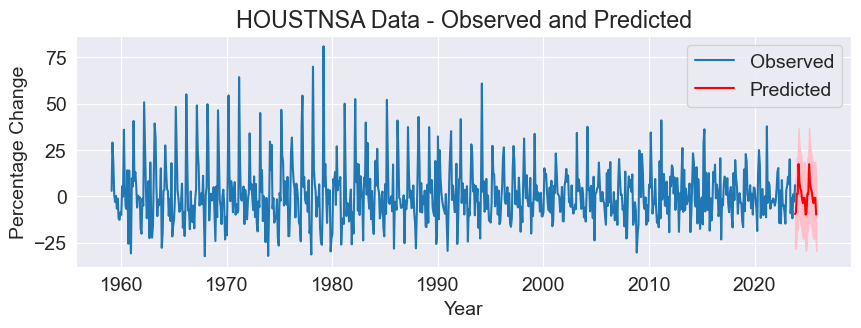

In [28]:
# 予測
dta_pred = res.get_prediction(start=pd.to_datetime('2023-11-01'),end=pd.to_datetime('2025-11-01'), dynamic=True)
dta_pred_conf_int = dta_pred.conf_int()

# グラフに描画
plt.figure(figsize=(10, 3))
plt.plot(dta, label='Observed')
plt.plot(dta_pred.predicted_mean, label='Predicted', color='r')

# 信頼区間の描画
plt.fill_between(dta_pred_conf_int.index, 
                 dta_pred_conf_int.iloc[:, 0], 
                 dta_pred_conf_int.iloc[:, 1], color='pink')

plt.legend()
plt.title('HOUSTNSA Data - Observed and Predicted')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.show()